In [99]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 400

In [3]:
def tophat(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 0.5 * width):
        return amplitude
    else:
        return 0.0

In [4]:
def gaussian(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return amplitude * math.exp( - ((x - convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [5]:
def yalla2021(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return math.cos(eta * (x-convected_distance)) * amplitude * math.exp( - ((x-convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [6]:
def tophatfv(func,x,dx,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs(abs((x-convected_distance) - center) - width / 2) < dx / 2) :
        return amplitude * (width / 2 - abs((x-convected_distance) - center) + dx / 2) / dx
    elif (abs((x-convected_distance) - center) < width / 2) :
        return amplitude
    else :
        return 0.0

In [7]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [8]:
def exact_sol_cell_average_scipy(func,x,dx,center,amplitude,width,eta,t) :
    integral = integrate.quad(func,x-dx/2,x+dx/2,args=(center,amplitude,width,eta,t))
    return integral[0]/dx

In [9]:
def exact_sol_cell_average_GLQ(func,x,dx,center,amplitude,width,eta,t) :
    w_i = [0.5555555556, 0.8888888889, 0.5555555556]
    dx_i = [-0.7745966692, 0, 0.7745966692]
    s = 0.0
    for i in range(len(w_i)) :
        s += w_i[i] * func(x + dx_i[i]*dx/2, center, amplitude, width, eta, t)
    return s/2

In [6]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
t_final = 0.5
Lx = 1.0
function = yalla2021

In [11]:
root_dir = '/home/dbeckers/tests/scalar_advection'

In [15]:
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

In [194]:
def postprocess_dist(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                ds = yt.load(plt_files[idx])
                ray = ds.ortho_ray(0, (0, 0))
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in ["x","temperature"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    return t, df["x"].values, df["temperature"].values
            

In [210]:
def postprocess_error(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = len(lines[1].split())-1
                    time = [float(line.split()[0]) for line in lines]
                    for level in reversed(range(error_levels)):
                        error = [float(line.split()[level+1]) for line in lines]
                        
                    if plotting == True:
                            if line_configuration == 1:
                                ax.plot(time, error, label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                            else:
                                ax.plot(time, error, label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    return time, error
            

In [179]:
def postprocess_convergence(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,line_configuration):
    
    dx_list = [1.0/grid_size for grid_size in grid_sizes]

    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            
            error_list = []
            
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                
                with open(error_file) as f:
                    lines = f.readlines()
                    error = float(lines[-1].split()[-1])
                    
                error_list.append(error)
        if line_configuration == 1:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color='black')
        else :
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color=line_colors[i_method])

                

# Animation to show scalar advection case

In [102]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
# t_final = 0.5
function = yalla2021

In [195]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 20

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1.3, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')
line, = ax.plot([], [], color='red',linewidth=1)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    t = i/(n_frames-1)*0.5
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    line.set_data(x_exact, scalar_exact)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)
anim.save('1-scalar_advection_case.gif')

In [196]:
anim

# Uniform grid: different methods with nx = 512

### Initial timestep

In [148]:
lw_exact = 0.5
ls_exact = 'dashed'

yt : [INFO     ] 2022-08-06 23:03:00,207 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-06 23:03:00,208 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:00,209 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:00,210 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 23:03:01,517 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-06 23:03:01,518 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:01,519 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:01,520 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 23:03:02,827 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-06 23:03:02,828 Parameters: domain_dimensions         = [512

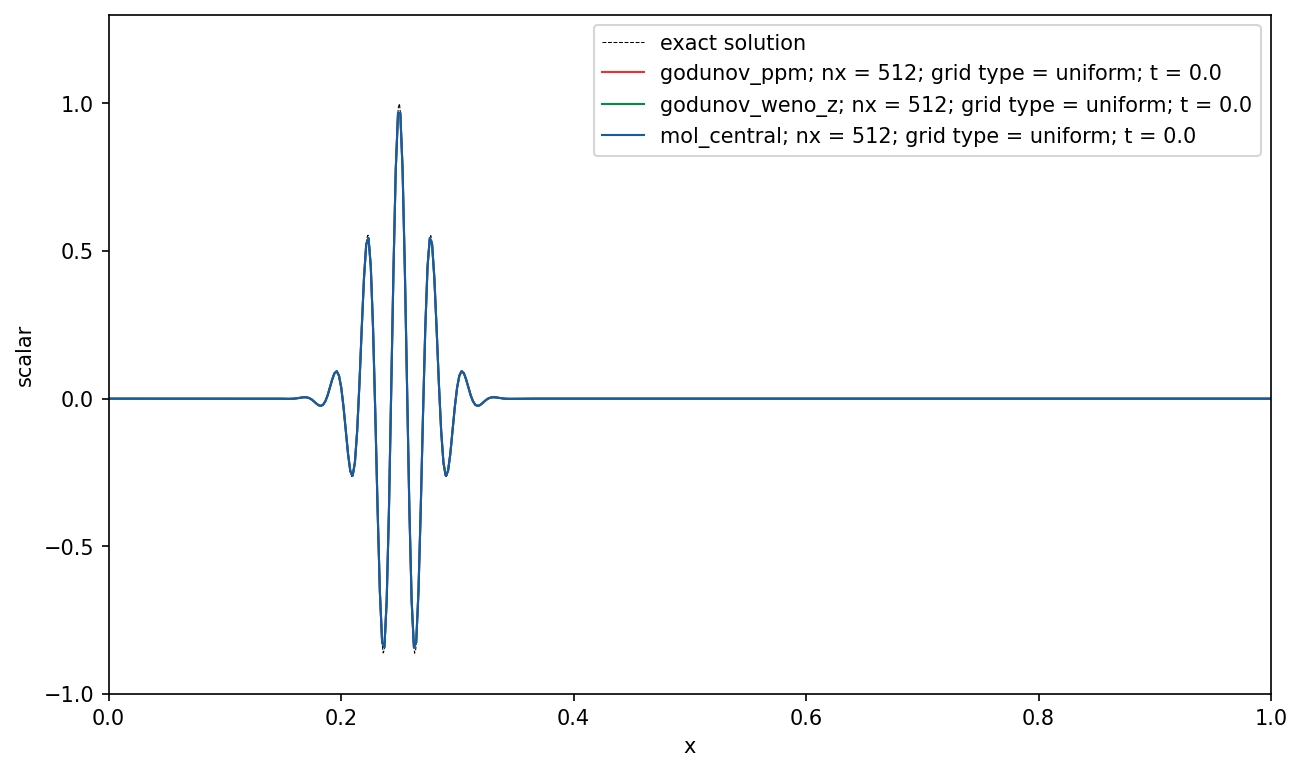

In [169]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('3-scalar_advection_uniform_initial.png')

### Final timestep

yt : [INFO     ] 2022-08-06 23:03:04,521 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 23:03:04,522 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:04,522 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:04,523 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]


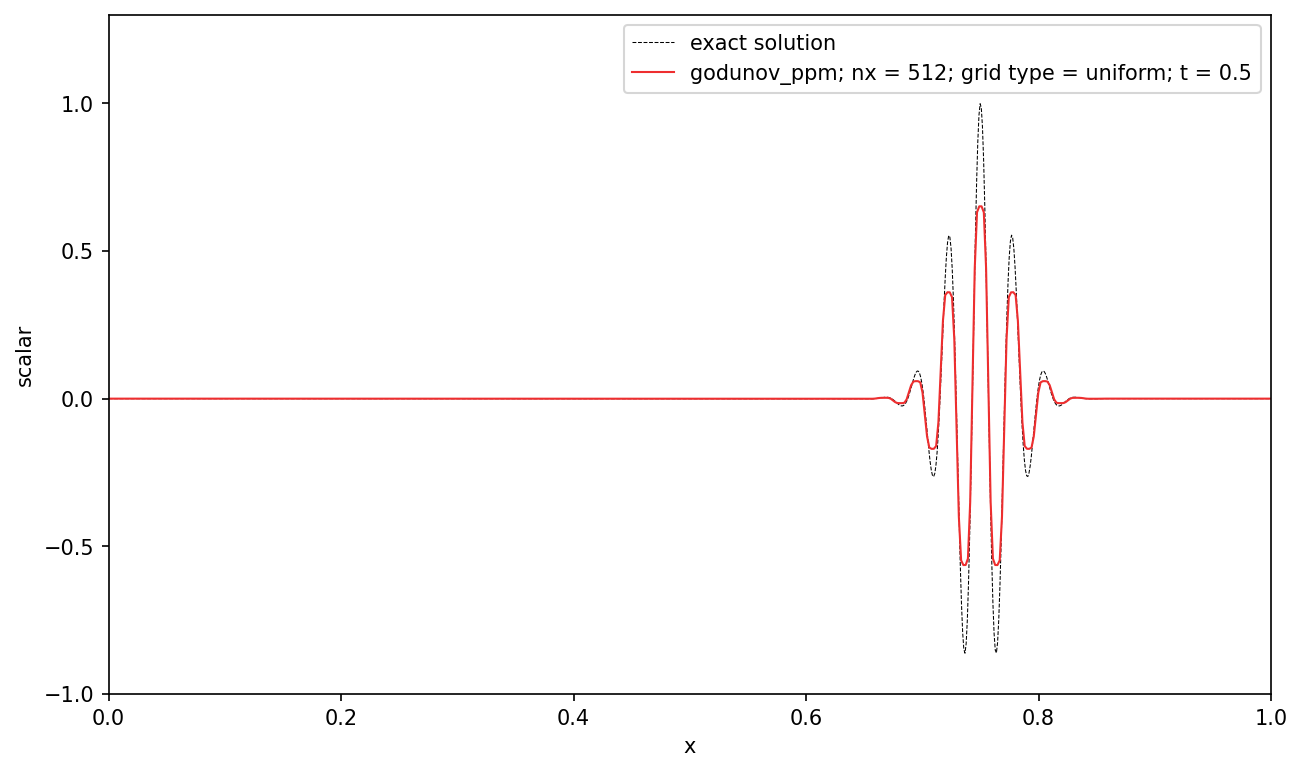

In [170]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4a-scalar_advection_uniform_final_godunov_ppm.png')

In [208]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 8

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1.3, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend()

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],False,2)
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('4a-scalar_advection_uniform_final_godunov_ppm.gif')

yt : [INFO     ] 2022-08-07 12:49:40,061 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 12:49:40,062 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 12:49:40,062 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 12:49:40,063 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 12:49:41,420 Parameters: current_time              = 0.0625
yt : [INFO     ] 2022-08-07 12:49:41,421 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 12:49:41,422 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 12:49:41,422 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 12:49:42,799 Parameters: current_time              = 0.125
yt : [INFO     ] 2022-08-07 12:49:42,800 Parameters: domain_dimensions         =

In [209]:
anim

yt : [INFO     ] 2022-08-07 12:49:51,873 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 12:49:51,874 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 12:49:51,875 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 12:49:51,875 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 12:49:53,286 Parameters: current_time              = 0.0625
yt : [INFO     ] 2022-08-07 12:49:53,287 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 12:49:53,287 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 12:49:53,288 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 12:49:54,686 Parameters: current_time              = 0.125
yt : [INFO     ] 2022-08-07 12:49:54,687 Parameters: domain_dimensions         =

yt : [INFO     ] 2022-08-06 23:03:06,161 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 23:03:06,162 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:06,162 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:06,163 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 23:03:07,445 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 23:03:07,445 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:07,446 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:07,447 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]


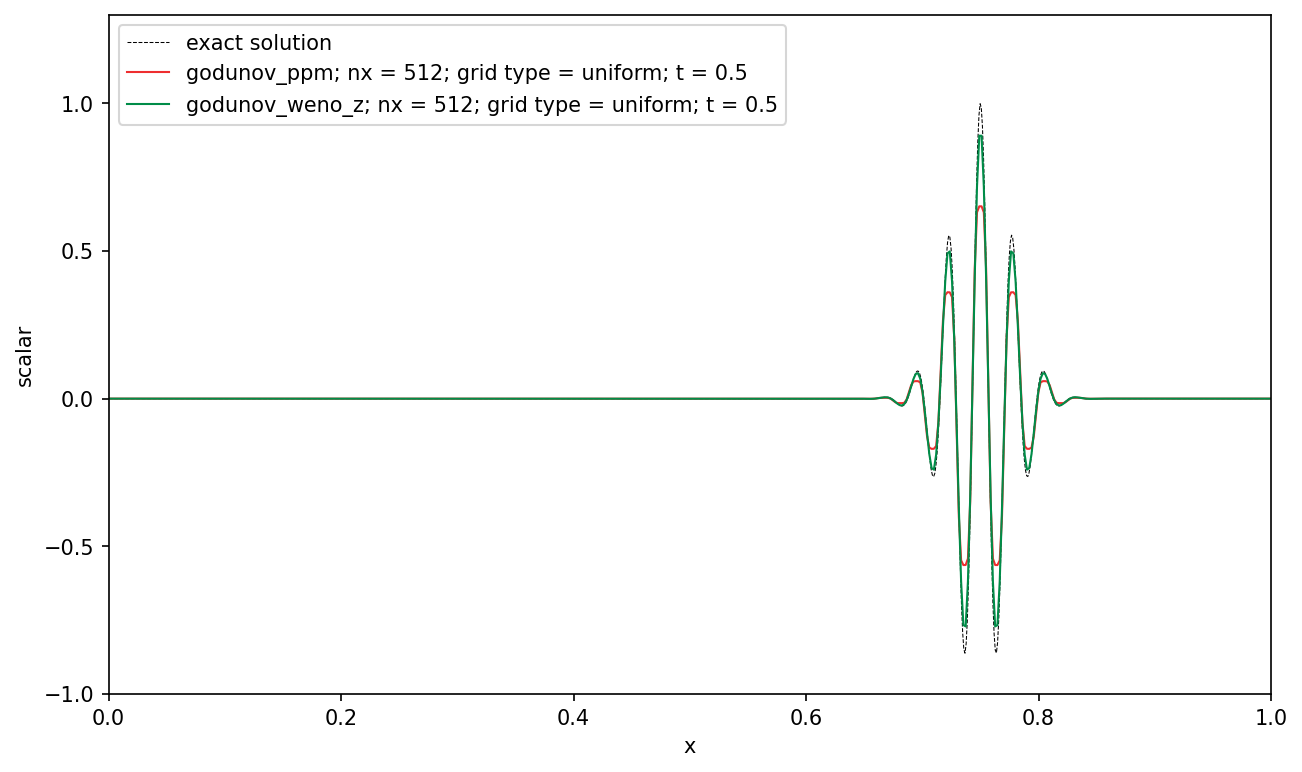

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4b-scalar_advection_uniform_final_godunov_ppm_weno_z.png')

yt : [INFO     ] 2022-08-06 23:03:09,668 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 23:03:09,669 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:09,670 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:09,671 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 23:03:11,094 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 23:03:11,095 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 23:03:11,095 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 23:03:11,096 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 23:03:12,446 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 23:03:12,447 Parameters: domain_dimensions         = [512

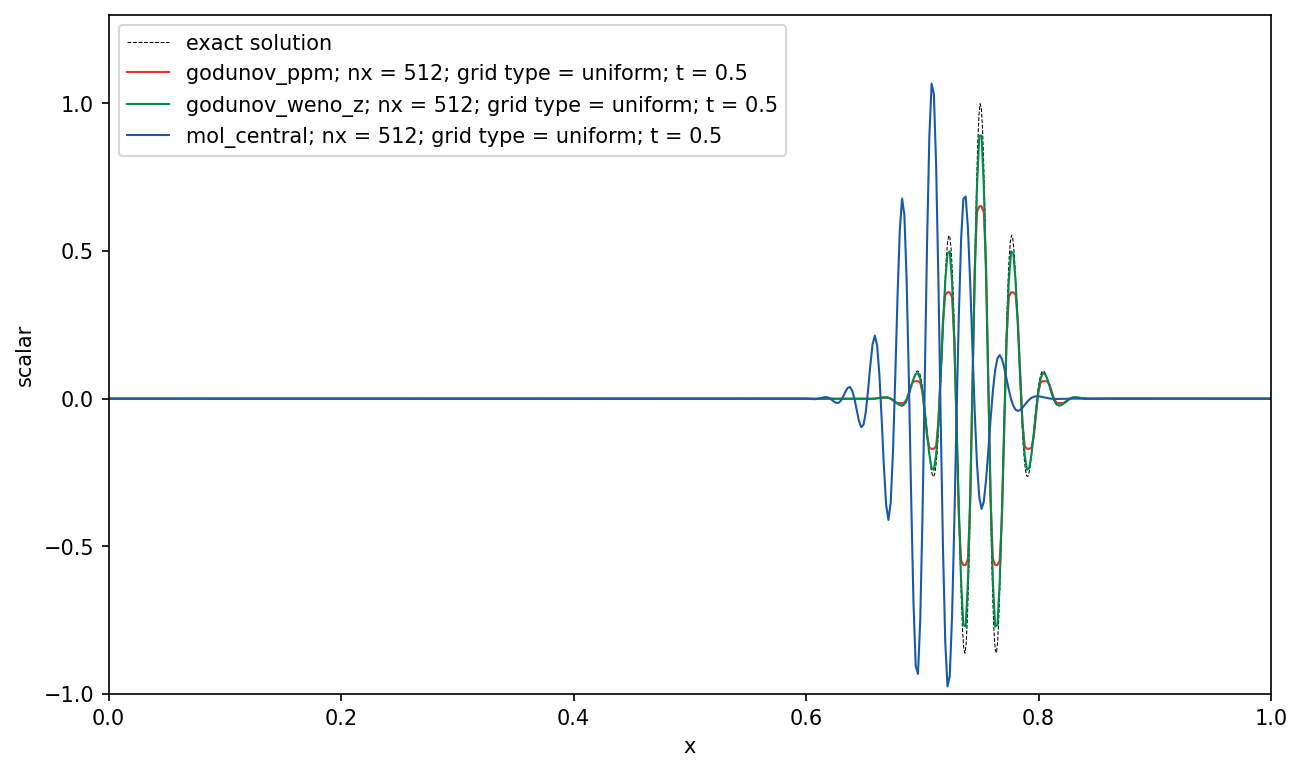

In [172]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4c-scalar_advection_uniform_final_godunov_ppm_weno_z_mol_central.png')

### Errors

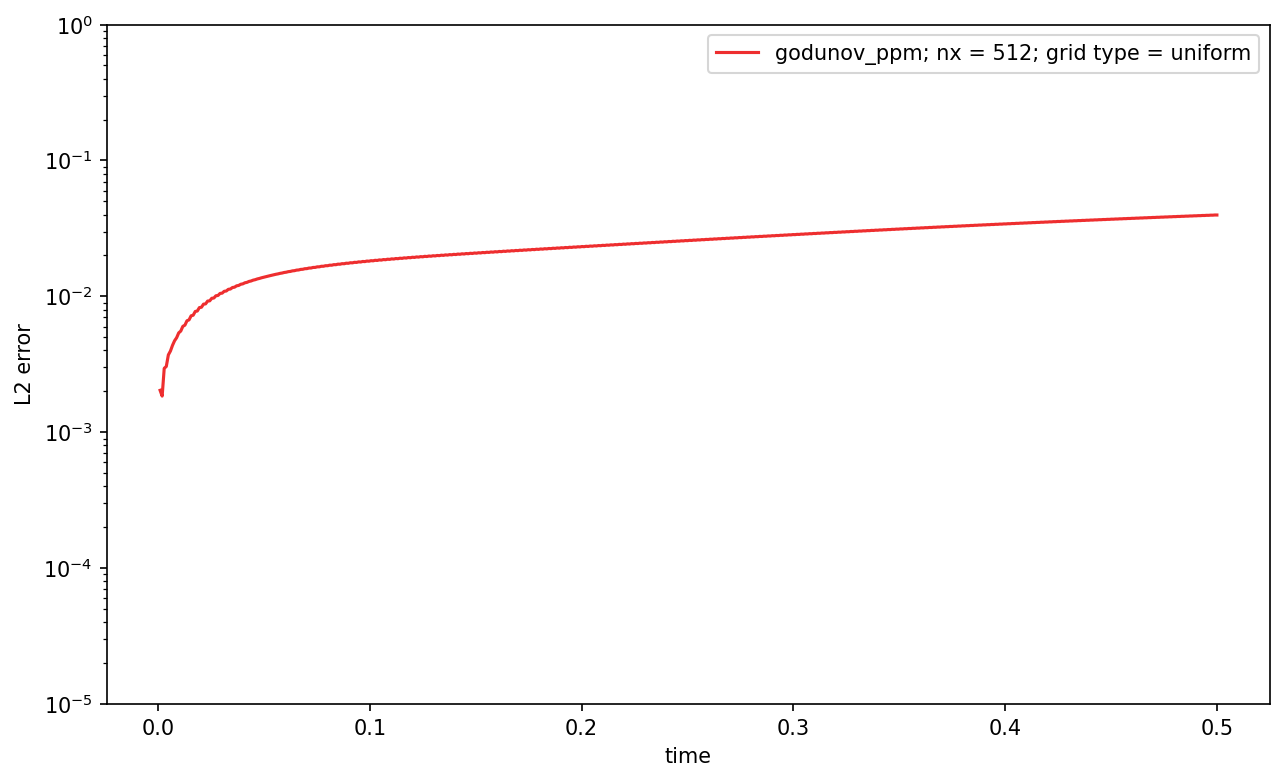

In [178]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,True,linewidth_list,2)

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_yscale('log')

fig.savefig('5a-scalar_advection_uniform_error_godunov_ppm.png')

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 8

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1.3, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

line = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]

def init():
    line.set_data([],[])
    return lines

def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',i,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],False,2)
    line.set_data(t,e)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('5a-scalar_advection_uniform_error_godunov_ppm.gif')

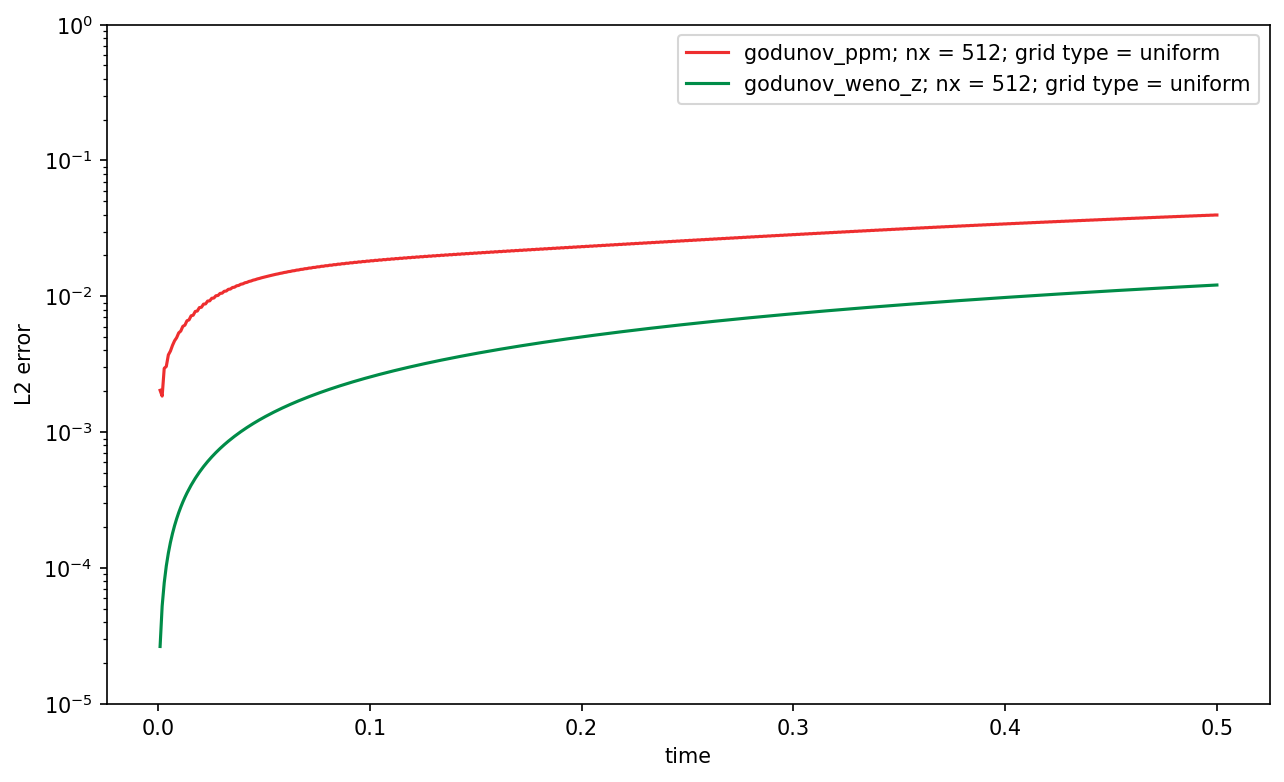

In [177]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,2)

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_yscale('log')

fig.savefig('5b-scalar_advection_uniform_error_godunov_ppm_weno_z.png')

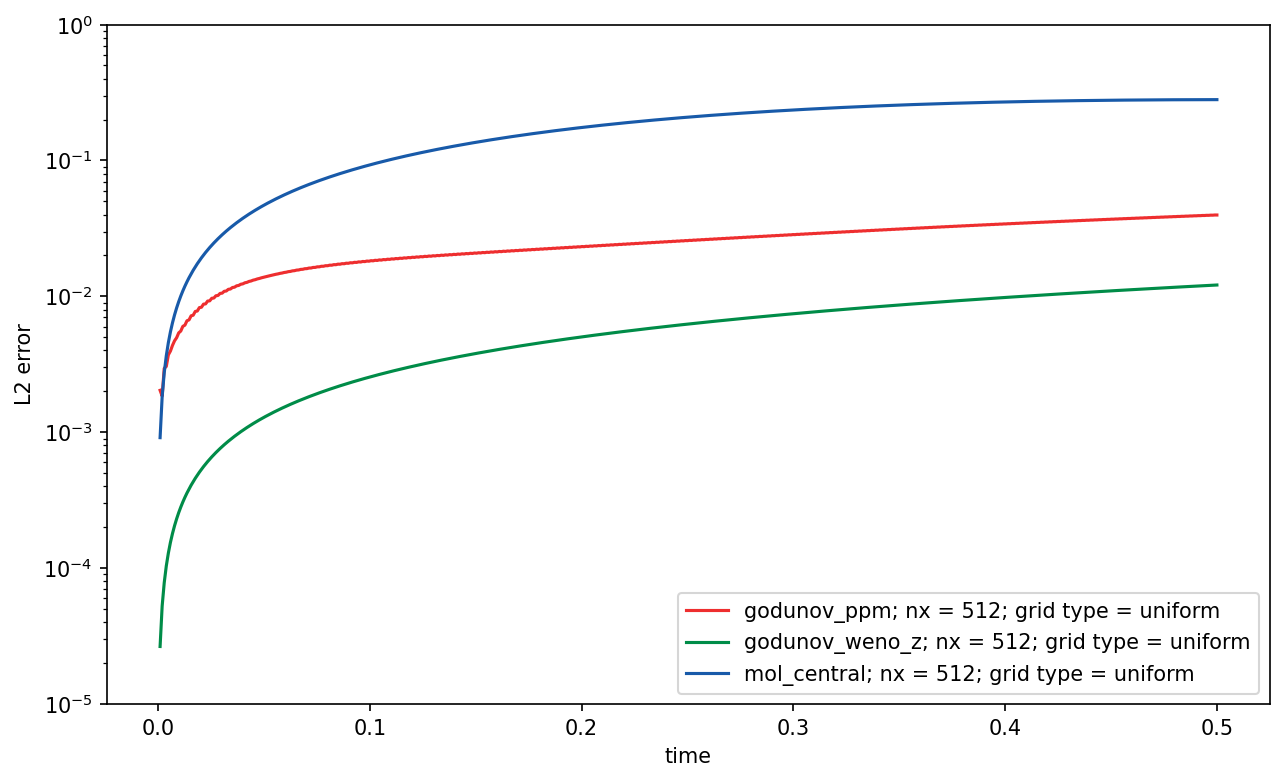

In [176]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,2)

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_yscale('log')

fig.savefig('5c-scalar_advection_uniform_error_godunov_ppm_weno_z_mol_central.png')

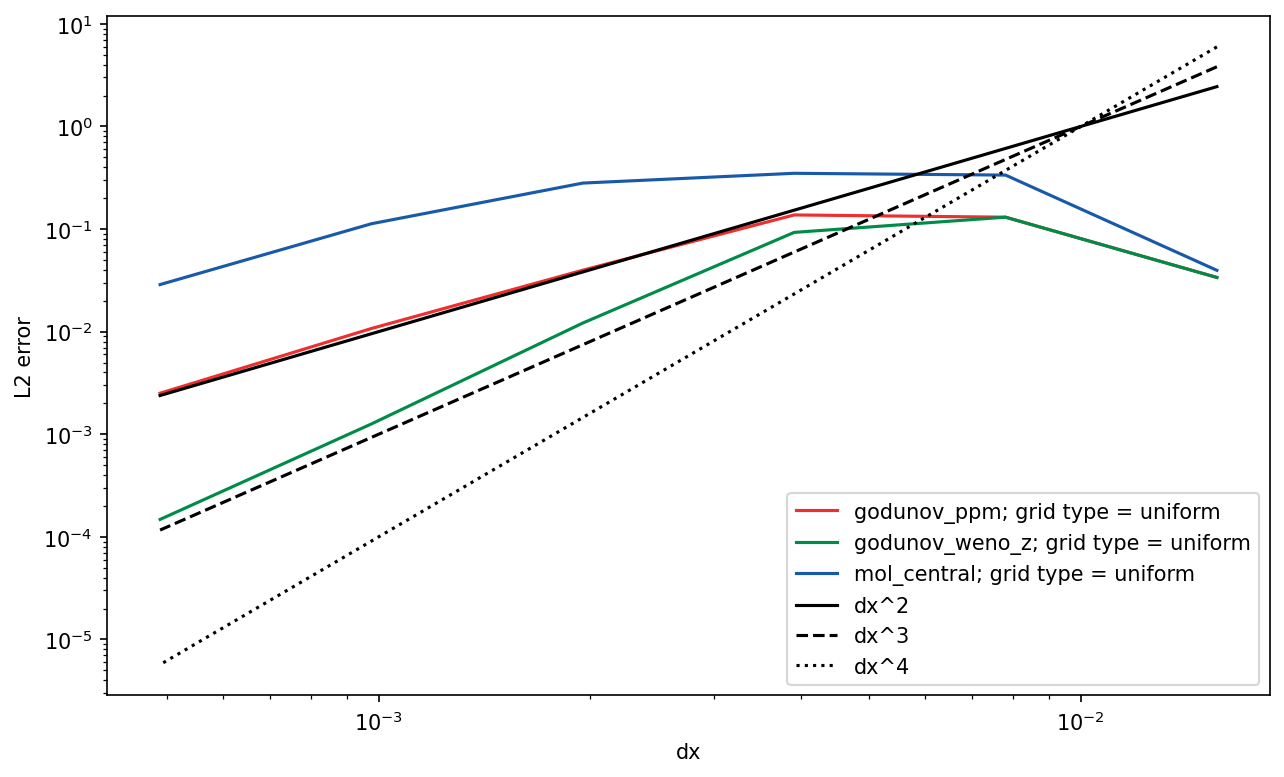

In [184]:
grid_sizes = [64,128,256,512,1024,2048]
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_convergence('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],grid_sizes,
                 ax,['solid','solid','solid'],color_list,linewidth_list,2)
dx_list = [1.0/grid_size for grid_size in grid_sizes]
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')

ax.legend()
ax.set_xlabel('dx')
ax.set_ylabel('L2 error')
ax.set_xscale('log')
ax.set_yscale('log')


fig.savefig('6-scalar_advection_uniform_error_convergence_all.png')